In [1]:
import pandas as pd

# Load the datasets
fear_greed_df = pd.read_csv("fear_greed_index.csv")
historical_df = pd.read_csv("historical_data.csv")

# Display a summary of each DataFrame
print("--- Fear & Greed Index Data Info ---")
fear_greed_df.info()

print("\n--- Historical Trader Data Info ---")
historical_df.info()

--- Fear & Greed Index Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB

--- Historical Trader Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Times

In [2]:
# Convert 'date' in the Fear & Greed Index to a datetime object
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

# Convert 'Timestamp IST' in the Historical Data to a date and then aggregate
historical_df['date'] = pd.to_datetime(historical_df['Timestamp IST'], dayfirst=True).dt.date

# Calculate the total PnL for each day
daily_pnl_df = historical_df.groupby('date')['Closed PnL'].sum().reset_index()
daily_pnl_df.rename(columns={'Closed PnL': 'Total_Daily_PnL'}, inplace=True)

# Convert the date column to datetime for the merge
daily_pnl_df['date'] = pd.to_datetime(daily_pnl_df['date'])

print("Daily PnL DataFrame:")
print(daily_pnl_df.head())

Daily PnL DataFrame:
        date  Total_Daily_PnL
0 2023-05-01         0.000000
1 2023-12-05         0.000000
2 2023-12-14      -205.434737
3 2023-12-15       -24.632034
4 2023-12-16         0.000000


In [3]:
# Merge the Fear & Greed data with the daily PnL data
merged_df = pd.merge(fear_greed_df, daily_pnl_df, on='date', how='inner')

print("\nMerged Data Summary:")
print(merged_df[['date', 'classification', 'value', 'Total_Daily_PnL']].head())


Merged Data Summary:
        date classification  value  Total_Daily_PnL
0 2023-05-01          Greed     63         0.000000
1 2023-12-05  Extreme Greed     75         0.000000
2 2023-12-14          Greed     72      -205.434737
3 2023-12-15          Greed     70       -24.632034
4 2023-12-16          Greed     67         0.000000


In [4]:
# Calculate the Mean Daily PnL for each sentiment classification
mean_pnl_by_sentiment = merged_df.groupby('classification')['Total_Daily_PnL'].mean().sort_values(ascending=False).reset_index()

# Calculate the win rate for each classification
merged_df['Winning_Day'] = merged_df['Total_Daily_PnL'] > 0
win_rate_by_sentiment = merged_df.groupby('classification')['Winning_Day'].mean().sort_values(ascending=False) * 100

print("--- Average PnL by Sentiment ---")
print(mean_pnl_by_sentiment)

print("\n--- Win Rate by Sentiment ---")
print(win_rate_by_sentiment)

# Calculate the correlation between FGI value and PnL
correlation = merged_df['value'].corr(merged_df['Total_Daily_PnL'])
print(f"\nCorrelation between FGI Value and Total Daily PnL: {correlation:.4f}")

--- Average PnL by Sentiment ---
  classification  Total_Daily_PnL
0   Extreme Fear     52793.589178
1           Fear     36891.818040
2  Extreme Greed     23817.292199
3        Neutral     19297.323516
4          Greed     11140.566181

--- Win Rate by Sentiment ---
classification
Extreme Greed    87.719298
Fear             73.626374
Greed            72.538860
Neutral          67.164179
Extreme Fear     64.285714
Name: Winning_Day, dtype: float64

Correlation between FGI Value and Total Daily PnL: -0.0826


Matplotlib is building the font cache; this may take a moment.
C:\Users\aiswa\AppData\Local\Temp\ipykernel_12608\144722401.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='Total_Daily_PnL', data=mean_pnl_by_sentiment, palette='viridis')


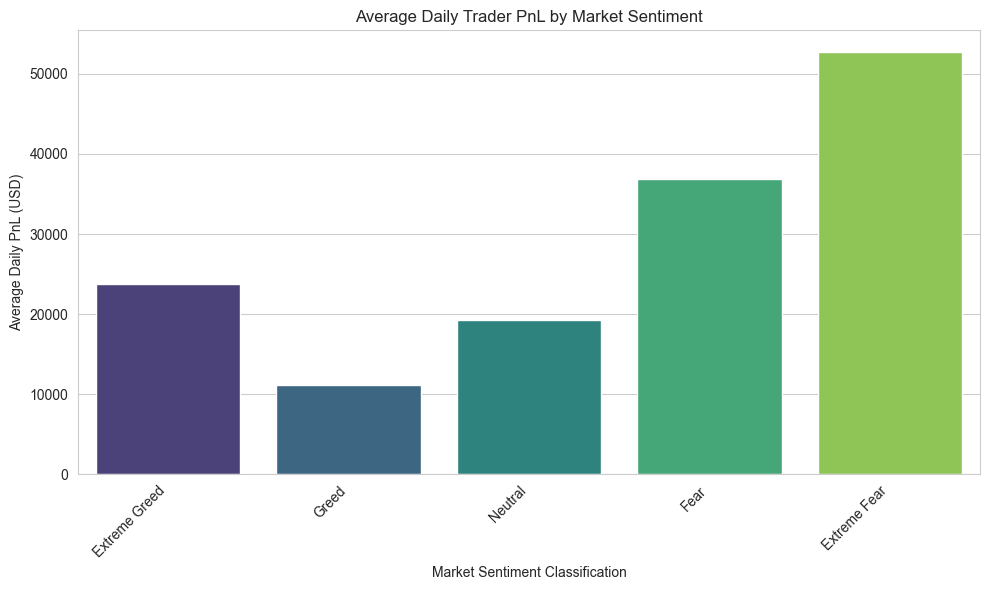

<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plot
sns.set_style("whitegrid")

# Create a custom order for the classifications to make the plot logical
sentiment_order = ['Extreme Greed', 'Greed', 'Neutral', 'Fear', 'Extreme Fear']

# Ensure the DataFrame is sorted for plotting
mean_pnl_by_sentiment['classification'] = pd.Categorical(mean_pnl_by_sentiment['classification'], categories=sentiment_order, ordered=True)
mean_pnl_by_sentiment.sort_values('classification', inplace=True)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='classification', y='Total_Daily_PnL', data=mean_pnl_by_sentiment, palette='viridis')
plt.title('Average Daily Trader PnL by Market Sentiment')
plt.xlabel('Market Sentiment Classification')
plt.ylabel('Average Daily PnL (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# You can save the figure to a file as well
plt.savefig('avg_pnl_by_sentiment_bar_chart.png')